# Production history analyser

This notebook aims at analysing the data published by RTE over the last 12 years.

In [2]:
# Modules import
if True:
    import math
    import sys
    import time

    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
# end if True

#### Analyzing functions

In [3]:
def nuke_units_separator(df):
    """Return two separate dictionnaries : nuclear units and conventional units.
    
    Input:
    - df : the DataFrame to analyse

    Outputs:
    - nuke_dict : the dictionnary containing nuclear units data
        - Nuclear technology (will not specify "Nuclear P'4" but only "P'4");
        - Capacity (MW).
    - not_nuke_dict : the dictionnary containing conventionnal units data
        - Technology;
        - Capacity (MW).
    """
    
    nuke_dict = {}
    not_nuke_dict = {}

    for column in df.columns:
        # For each unit in the DataFrame, add the corresponding key and values to nuke_dict (not_nuke_dict if option enabled)
        if df[column]["Technology"].startswith("Nucléaire"):
            nuke_dict.update({
                column : {
                    "Technology" : df[column]["Technology"].split(" ")[1],
                    "Capacity (MW)":float(df[column]["Capacity (MW)"])
                    }
                })
        else:
            not_nuke_dict.update({
                column : {
                    "Technology" : df[column]["Technology"], 
                    "Capacity (MW)":float(df[column]["Capacity (MW)"])
                    }
                })
        #end if
    #end for
    
    return nuke_dict, not_nuke_dict

######################################################################################################################################
def df_shaper(df, excluded_units_dict={}):
    """Exclude units from the original df and return the corresponding dataframe with data as floats and index as pd.Timestamp."""
    df_1 = df.drop(["Technology", "Capacity (MW)"], axis=0).drop(excluded_units_dict.keys(), axis=1).astype("float")
    df_1.index = pd.to_datetime(df_1.index)
    return df_1

######################################################################################################################################
def df_study_shaper(df, included_units_dict, study_dates_dict):
    """Returns the dataframe with specified units."""
    study_df = df.loc[study_dates_dict["start_date"]:study_dates_dict["end_date"], included_units_dict.keys()]

    return study_df

######################################################################################################################################
def df_offsetting_tool(df, offset=0):
    """Returns df with offset lines of NaN at the beginning and offset lines dropped at the end"""
    return df.shift(offset)

######################################################################################################################################
def data_quality_evaluation(df):
    """Return the ratio of corrupted values in the data available for given units during a given period."""
    # Calculate the duration of the study period
    duration = len(df.index)

    # Calculate the ratio of corrupted values for each unit using vectorized operations
    unit_quality = pd.isna(df).sum() / duration

    # Create the data quality dictionary
    data_quality_dict = {"Average": unit_quality.mean()}
    data_quality_dict.update({f"{column}'s": value for column, value in unit_quality.items()})

    return data_quality_dict

######################################################################################################################################
def relative_dataframe(df, study_dict):
    """Return the normalized dataframe in % of nominal power of each unit."""
    df_relative = df.copy()

    for column in df.columns:
        df_relative[column] = df_relative[column]/study_dict[column]["Capacity (MW)"]
    
    return df_relative

######################################################################################################################################
def ramps_dataframe(df_relative):
    """Return the dataframe of evolution in % of nominal power of each unit."""
    return df_relative.diff(1)

######################################################################################################################################
def df_ramps_filter(df_ramps, abs_rate_lb=0, neg_filter=True, abs_rate_ub=1):
    """Return the dataframe of ramps after filtering ramps on rate."""
    # Create a boolean mask to filter the ramps based on the rate limits
    if neg_filter:
        # Consider only ramps going up with a rate between the limits
        mask = (df_ramps >= abs_rate_lb) & (df_ramps <= abs_rate_ub)
    else:
        # Consider the absolute rate of ramps going up or down
        mask = (abs(df_ramps) >= abs_rate_lb) & (abs(df_ramps) <= abs_rate_ub)

    # Use the mask to filter the ramps
    df_ramps_filtered = df_ramps.where(mask, np.nan)

    return df_ramps_filtered

######################################################################################################################################
def Load_following_study(relative_df, ramps_df):
    """Returns a boolean DataFrame indicating if units are engaged in load following or not."""
    return ((abs(ramps_df) < 0.1) & (relative_df < 0.976)).astype("int")

## Initialisation of nuke_df

#### Global dataframe loading

In [4]:
filename = "./Processed_data/dataframe_RTE_without_outliers.csv.xz"                 # Global dataframe compressed into a .csv.xz with all 2011-2023 data

cleaned_df = pd.read_csv(filename, index_col=0, low_memory=False)                   # Datatypes are mixed in the DataFrame, hence it is suggested to disable chunking
print("Cleaned DataFrame extracted and loaded")

Cleaned DataFrame extracted and loaded


In [5]:
filename2 = "./Processed_data/dataframe_creditK.csv.xz"                              # Global dataframe compressed into a .csv.xz with all 2011-2023 data

creditK_df = pd.read_csv(filename2, index_col=0, low_memory=False)                   # Datatypes are mixed in the DataFrame, hence it is suggested to disable chunking
print("Crédit K DataFrame extracted and loaded")

Crédit K DataFrame extracted and loaded


#### Nuclear units extraction

In [6]:
nuke_dict, not_nuke_dict = nuke_units_separator(cleaned_df)

print("Nuclear units extracted in nuke_dict")
# print(nuke_dict)
# print(not_nuke_dict)

Nuclear units extracted in nuke_dict


In [7]:
nuke_df = df_shaper(cleaned_df, not_nuke_dict)

creditK_df = creditK_df.astype("int")
creditK_df.index = pd.to_datetime(creditK_df.index)

print("DataFrame truncated to nuclear units")
# print(nuke_df)

DataFrame truncated to nuclear units


## Selective analysis

### Analysis preparation

#### Preliminary set initialisation

In [8]:
study_list_bugey = ["BUGEY 2", "BUGEY 3", "BUGEY 4", "BUGEY 5"]
study_list_fessenheim = ["FESSENHEIM 1", "FESSENHEIM 2"]
study_list_CP0 = study_list_bugey + study_list_fessenheim

study_list_blayais = ["BLAYAIS 1", "BLAYAIS 2", "BLAYAIS 3", "BLAYAIS 4"]
study_list_dampierre = ["DAMPIERRE 1", "DAMPIERRE 2", "DAMPIERRE 3", "DAMPIERRE 4"]
study_list_gravelines = ["GRAVELINES 1", "GRAVELINES 2", "GRAVELINES 3", "GRAVELINES 4", "GRAVELINES 5", "GRAVELINES 6"]
study_list_tricastin = ["TRICASTIN 1", "TRICASTIN 2", "TRICASTIN 3", "TRICASTIN 4"]
study_list_CP1 = study_list_blayais + study_list_dampierre + study_list_gravelines + study_list_tricastin

study_list_chinon_B = ["CHINON B 1", "CHINON B 2", "CHINON B 3", "CHINON B 4"]
study_list_cruas = ["CRUAS 1", "CRUAS 2", "CRUAS 3", "CRUAS 4"]
study_list_st_laurent = ["ST LAURENT 1", "ST LAURENT 2"]
study_list_CP2 = study_list_chinon_B + study_list_cruas + study_list_st_laurent

study_list_CPY = study_list_CP1 + study_list_CP2

study_list_flamanville = ["FLAMANVILLE 1", "FLAMANVILLE 2"]
study_list_paluel = ["PALUEL 1", "PALUEL 2", "PALUEL 3", "PALUEL 4"]
study_list_st_alban = ["ST ALBAN 1", "ST ALBAN 2"]
study_list_P4 = study_list_flamanville + study_list_paluel + study_list_st_alban

study_list_belleville = ["BELLEVILLE 1", "BELLEVILLE 2"]
study_list_cattenom = ["CATTENOM 1", "CATTENOM 2", "CATTENOM 3", "CATTENOM 4"]
study_list_golfech = ["GOLFECH 1", "GOLFECH 2"]
study_list_nogent = ["NOGENT 1", "NOGENT 2"]
study_list_penly = ["PENLY 1", "PENLY 2"]
study_list_P4p = study_list_belleville + study_list_cattenom + study_list_golfech + study_list_nogent + study_list_penly

study_list_P4P4p = study_list_P4 + study_list_P4p

study_list_chooz_b = ["CHOOZ B 1", "CHOOZ B 2"]
study_list_civaux = ["CIVAUX 1", "CIVAUX 2"]
study_list_N4 = study_list_chooz_b + study_list_civaux

study_list_park = study_list_CP0 + study_list_CPY + study_list_P4P4p + study_list_N4

study_list_problems = []

#### Analysis parameters

In [9]:
study_list0 = ["BUGEY 2", "BLAYAIS 1", "CRUAS 3", "ST ALBAN 1", "GOLFECH 2", "CIVAUX 2"]

study_list = study_list_park
#study_list = nuke_dict.keys()
study_period = {"start_date" : pd.to_datetime("2011-12-13 00:00:00"), "end_date" : pd.to_datetime("2023-12-31 23:00:00")}
# study_period = {"start_date" : pd.to_datetime("2022-05-01 00:00:00"), "end_date" : pd.to_datetime("2022-09-30 23:00:00")}
refuelling_duration = "26 d"

study_dict = {unit:nuke_dict[unit] for unit in study_list}
print(study_dict)

{'BUGEY 2': {'Technology': 'CP0', 'Capacity (MW)': 910.0}, 'BUGEY 3': {'Technology': 'CP0', 'Capacity (MW)': 910.0}, 'BUGEY 4': {'Technology': 'CP0', 'Capacity (MW)': 880.0}, 'BUGEY 5': {'Technology': 'CP0', 'Capacity (MW)': 880.0}, 'FESSENHEIM 1': {'Technology': 'CP0', 'Capacity (MW)': 880.0}, 'FESSENHEIM 2': {'Technology': 'CP0', 'Capacity (MW)': 880.0}, 'BLAYAIS 1': {'Technology': 'CP1', 'Capacity (MW)': 910.0}, 'BLAYAIS 2': {'Technology': 'CP1', 'Capacity (MW)': 910.0}, 'BLAYAIS 3': {'Technology': 'CP1', 'Capacity (MW)': 910.0}, 'BLAYAIS 4': {'Technology': 'CP1', 'Capacity (MW)': 910.0}, 'DAMPIERRE 1': {'Technology': 'CP1', 'Capacity (MW)': 890.0}, 'DAMPIERRE 2': {'Technology': 'CP1', 'Capacity (MW)': 890.0}, 'DAMPIERRE 3': {'Technology': 'CP1', 'Capacity (MW)': 890.0}, 'DAMPIERRE 4': {'Technology': 'CP1', 'Capacity (MW)': 890.0}, 'GRAVELINES 1': {'Technology': 'CP1', 'Capacity (MW)': 910.0}, 'GRAVELINES 2': {'Technology': 'CP1', 'Capacity (MW)': 910.0}, 'GRAVELINES 3': {'Technolog

In [10]:
study_df = df_study_shaper(nuke_df, study_dict, study_period)
creditK_study_df = df_study_shaper(creditK_df, study_dict, study_period)
study_dates_df = pd.DataFrame(study_df.index, index=study_df.index).rename(columns={"DATE" : "DATES col"})
print("Study Dataframe generated, tailored to units and period given")
# print(study_df)

Study Dataframe generated, tailored to units and period given


#### Data quality assessment

In [11]:
data_quality_dict = data_quality_evaluation(study_df)

for unit in data_quality_dict.keys():
    print(f"{unit} data quality: {data_quality_dict[unit]*100:.1f} % of NaN in data")
#end for

Average data quality: 1.2 % of NaN in data
BUGEY 2's data quality: 0.5 % of NaN in data
BUGEY 3's data quality: 0.5 % of NaN in data
BUGEY 4's data quality: 1.2 % of NaN in data
BUGEY 5's data quality: 0.8 % of NaN in data
FESSENHEIM 1's data quality: 1.4 % of NaN in data
FESSENHEIM 2's data quality: 1.4 % of NaN in data
BLAYAIS 1's data quality: 1.3 % of NaN in data
BLAYAIS 2's data quality: 2.3 % of NaN in data
BLAYAIS 3's data quality: 0.8 % of NaN in data
BLAYAIS 4's data quality: 0.9 % of NaN in data
DAMPIERRE 1's data quality: 0.6 % of NaN in data
DAMPIERRE 2's data quality: 1.3 % of NaN in data
DAMPIERRE 3's data quality: 1.3 % of NaN in data
DAMPIERRE 4's data quality: 0.7 % of NaN in data
GRAVELINES 1's data quality: 0.8 % of NaN in data
GRAVELINES 2's data quality: 3.6 % of NaN in data
GRAVELINES 3's data quality: 0.5 % of NaN in data
GRAVELINES 4's data quality: 0.8 % of NaN in data
GRAVELINES 5's data quality: 0.6 % of NaN in data
GRAVELINES 6's data quality: 1.0 % of NaN i

#### Relative power calculation

In [12]:
relative_df = relative_dataframe(study_df, study_dict)

print("DataFrame of relative power generated")
# print(relative_df)

DataFrame of relative power generated


### Analysis results

In [13]:
print(f"Plotting results from {study_period['start_date']} to {study_period['end_date']}")

Plotting results from 2011-12-13 00:00:00 to 2023-12-31 23:00:00


#### Crédit K plot

<AxesSubplot:title={'center':'Crédit K profile'}, xlabel='DATE'>

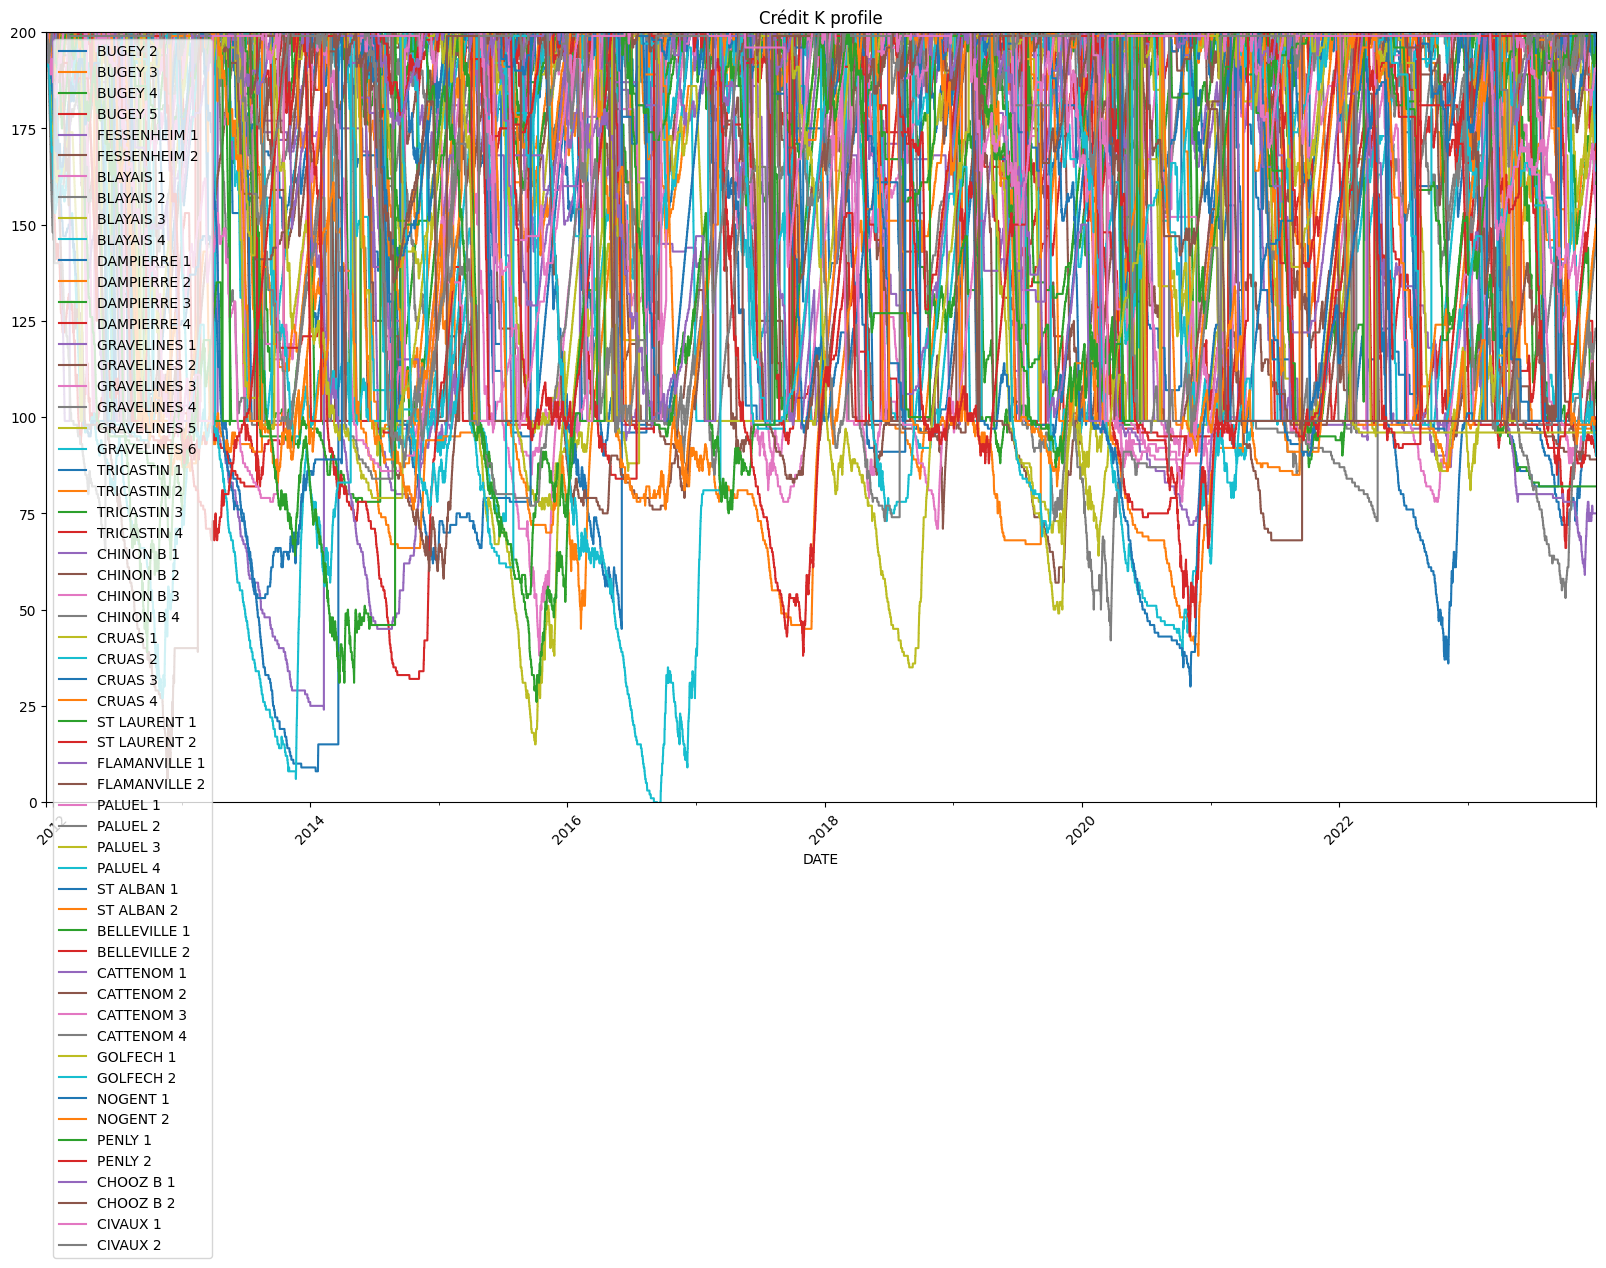

In [14]:
creditK_study_df[study_list].plot(figsize=(20,10), rot=45, title="Crédit K profile", ylim=(0,200))

#### Relative power plot

<AxesSubplot:title={'center':'Relative power profile'}, xlabel='DATE'>

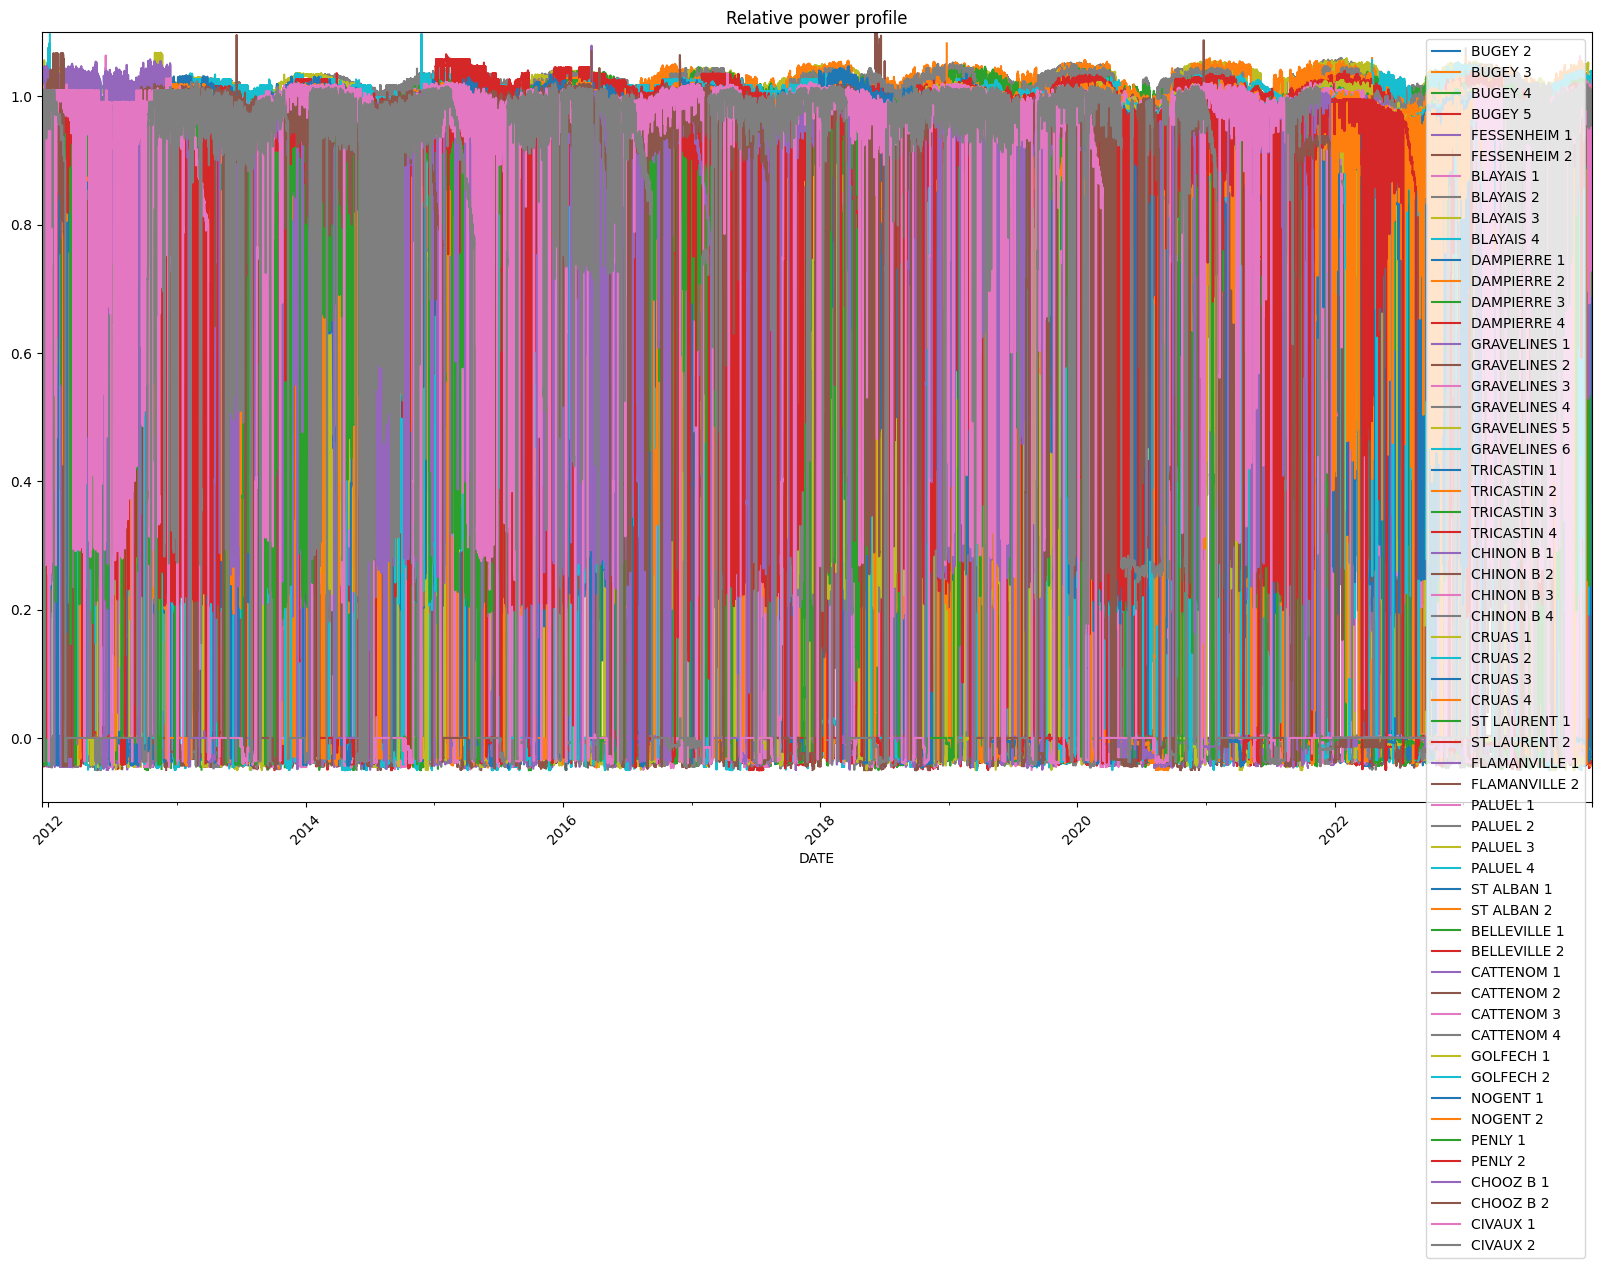

In [15]:
relative_df[study_list].plot(figsize=(20,10), rot=45, title="Relative power profile", ylim=(-0.1,1.1))

#### Crédit K usage analysis

This usage analysis is based on the area between the curves and the K = 100 level (K < 100 considered to be = 100 conservatively). This K = 100 threshold accounts for possible methodology misunderstanding and avoids non-conservative processing of data. That said, EDF STE indicates that below K = 100, load-following does not affect crédit K with or without remote control. The exact definition of load-following being unclear at that point incitate to focus on the conservative part K >= 100.

A value close to 1 indicates that the reactor was not maneuvering a lot or that crédit K was not the operational limit to flexibility.

In [16]:
cK_df = (creditK_study_df - 100)/100/(pd.Timedelta(study_period["end_date"] - study_period["start_date"]).total_seconds() / 60 / 60)
cK_df[cK_df < 0] = 0

In [17]:
print(cK_df.sum())
print(f"The average on park is {cK_df.sum().mean()}")

BUGEY 2          0.836075
BUGEY 3          0.790615
BUGEY 4          0.791136
BUGEY 5          0.873360
FESSENHEIM 1     0.801255
FESSENHEIM 2     0.831987
BLAYAIS 1        0.799226
BLAYAIS 2        0.839266
BLAYAIS 3        0.973626
BLAYAIS 4        0.784146
DAMPIERRE 1      0.657823
DAMPIERRE 2      0.782639
DAMPIERRE 3      0.948218
DAMPIERRE 4      0.795776
GRAVELINES 1     0.727542
GRAVELINES 2     0.756140
GRAVELINES 3     0.779281
GRAVELINES 4     0.950803
GRAVELINES 5     0.808239
GRAVELINES 6     0.911859
TRICASTIN 1      0.701119
TRICASTIN 2      0.863227
TRICASTIN 3      0.921828
TRICASTIN 4      0.770667
CHINON B 1       0.752106
CHINON B 2       0.739628
CHINON B 3       0.811691
CHINON B 4       0.862044
CRUAS 1          0.880266
CRUAS 2          0.618889
CRUAS 3          0.909044
CRUAS 4          0.819583
ST LAURENT 1     0.736259
ST LAURENT 2     0.532675
FLAMANVILLE 1    0.644882
FLAMANVILLE 2    0.633405
PALUEL 1         0.646126
PALUEL 2         0.675426
PALUEL 3    

In [20]:
multiindex = pd.MultiIndex.from_frame(pd.DataFrame([[study_dict[column]["Technology"], column] for column in study_dict.keys()], columns=["Technology", "Unit"]))
cK_df.columns = multiindex

In [21]:
# print(cK_df.sum())

for technology in cK_df.columns.levels[0]:
    print(f"Average crédit K remaining for technology {technology} : {cK_df[technology].sum().mean()}")

Average crédit K remaining for technology CP0 : 0.8207379764688065
Average crédit K remaining for technology CP1 : 0.8206347290715517
Average crédit K remaining for technology CP2 : 0.7662184065804046
Average crédit K remaining for technology N4 : 0.8213813690876219
Average crédit K remaining for technology P'4 : 0.565151763261932
Average crédit K remaining for technology P4 : 0.5824379182560793
